In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import numpy as np


import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset

#Get rid of SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  


In [2]:
PNW = pd.read_csv('../../Data/processedData/PNW/PNW.csv')
PNW = PNW.dropna()
PNW["flowering"] = PNW['reproductiveCondition'].isin(['flowering','flowering|fruiting','flowering|fruiting|flower budding','flowering|flower budding']).astype(int)
PNW["fruiting"] = PNW['reproductiveCondition'].isin(['fruiting','flowering|fruiting','flowering|fruiting|flower budding','fruiting|flower budding']).astype(int)

photoPath = "../../../PNW_Angiosperms/labeled_photos"

In [3]:
#I only have 49,999 so I'm missing one photo. The following code drops that row from the dataframe
for fname in PNW['file_name']: 
    if not os.path.isfile(photoPath + "/" + fname):
        PNW = PNW[PNW['file_name'] != fname]

In [4]:
photos = PNW[["file_name", "flowering"]].reset_index(drop=True)
photos_train, photos_val = train_test_split(list(photos.index), test_size=.25)
p_train= photos.iloc[photos_train]
p_val = photos.iloc[photos_val]

In [5]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#Some of our images are .pngs, we drop the alpha. 
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor()
                            ])

target_transform = transforms.Compose([
                                transforms.Lambda(lambda x: torch.tensor(x).long()),
                            ])                         

In [11]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, label_frame, img_dir, transform=None, target_transform=None):
        self.img_labels = label_frame
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
train_data = CustomImageDataset(p_train, photoPath, transform, target_transform)
val_data = CustomImageDataset(p_val, photoPath, transform, target_transform)

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 75, 75])
Labels batch shape: torch.Size([64])


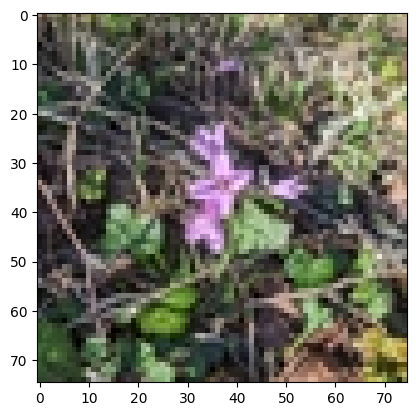

Label: 1


In [14]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [13]:
type(train_labels[0].item())

int

In [16]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(14400, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [17]:
model = ConvNeuralNet(2).to(device)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [20]:
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    
    #Turn the model into training mode
    model.train()

    for data, target in train_dataloader:
        optimizer.zero_grad()
        data = data.to(device)
        output = model(data)
        target=target.to(device)   
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        train_correct += (pred == target).sum().item()

    train_loss /= len(train_dataloader.dataset)
    train_acc = 100.0 * train_correct / len(train_dataloader.dataset)

    test_loss = 0.0
    test_correct = 0
    model.eval()

    with torch.no_grad():
        for data, target in val_dataloader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, 1)
            test_correct += (pred == target).sum().item()

    test_loss /= len(val_dataloader.dataset)
    test_acc = 100.0 * test_correct / len(val_dataloader.dataset)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch 1: Train Loss: 0.6022, Train Acc: 68.55%, Test Loss: 0.5922, Test Acc: 68.28%
Epoch 2: Train Loss: 0.5891, Train Acc: 68.52%, Test Loss: 0.5867, Test Acc: 68.20%
Epoch 3: Train Loss: 0.5844, Train Acc: 68.67%, Test Loss: 0.5834, Test Acc: 68.41%
Epoch 4: Train Loss: 0.5776, Train Acc: 68.80%, Test Loss: 0.5753, Test Acc: 68.46%
Epoch 5: Train Loss: 0.5668, Train Acc: 69.20%, Test Loss: 0.5645, Test Acc: 68.94%
Epoch 6: Train Loss: 0.5559, Train Acc: 69.58%, Test Loss: 0.5604, Test Acc: 69.30%
Epoch 7: Train Loss: 0.5507, Train Acc: 69.95%, Test Loss: 0.5569, Test Acc: 69.13%
Epoch 8: Train Loss: 0.5469, Train Acc: 70.18%, Test Loss: 0.5545, Test Acc: 69.34%
Epoch 9: Train Loss: 0.5439, Train Acc: 70.44%, Test Loss: 0.5531, Test Acc: 69.76%
Epoch 10: Train Loss: 0.5390, Train Acc: 70.71%, Test Loss: 0.5510, Test Acc: 69.74%
Epoch 11: Train Loss: 0.5364, Train Acc: 70.52%, Test Loss: 0.5571, Test Acc: 68.38%
Epoch 12: Train Loss: 0.5345, Train Acc: 70.91%, Test Loss: 0.5539, Test A